In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import os
from glob import glob
import sys
import random

from tqdm import tqdm_notebook
from skimage.io import imread, imshow
from skimage.transform import resize

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as dsets
from torch.autograd import Variable
import cv2
import sklearn.metrics 
from pathlib import Path

In [2]:

def conv3x3(in_channels, out_channels, stride=1, dilation=1, padding=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride,
                     padding=padding, bias=False, dilation=dilation)
# Residual Block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None, 
                 dilation=1, padding=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = conv3x3(in_channels, out_channels, stride, dilation, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(out_channels, out_channels, dilation, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

# ResNet Module
class ResNet(nn.Module):
    def __init__(self, layers, num_classes=1):
        super(ResNet, self).__init__()
        self.in_channels = 16
        self.conv = conv3x3(1, 16)
        self.bn = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self.make_layer(16, layers[0], 1,1)
        self.layer2 = self.make_layer(32, layers[0], 1,2,2)
        self.layer3 = self.make_layer(64, layers[1], 1,4,4)
        #self.avg_pool = nn.AvgPool2d(8)
        #self.fc = nn.Linear(64, num_classes)
        self.convL = conv3x3(64,1)

    def make_layer(self, out_channels, blocks, stride=1, dilation=1, padding=1):
        downsample = None
        if (padding != 1) or (self.in_channels != out_channels):
            downsample = nn.Sequential(
                conv3x3(self.in_channels, out_channels, stride=stride,dilation=dilation, padding = padding),
                nn.BatchNorm2d(out_channels))
        layers = []
        layers.append(ResidualBlock(self.in_channels, out_channels, stride, downsample))   # Major change here
        self.in_channels = out_channels
        for i in range(1, blocks):
            layers.append(ResidualBlock(out_channels, out_channels))    # Major change here
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = self.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        #out = self.avg_pool(out)
        #out = out.view(out.size(0), -1)
        #out = self.fc(out)
        out = self.convL(out)
        return out


In [3]:
class eye_dataset(torch.utils.data.Dataset):

    def __init__(self,preprocessed_images, train=True, preprocessed_masks=None):
        """
        Args:
            text_file(string): path to text file
            root_dir(string): directory with all train images
        """
        self.train = train
        self.images = preprocessed_images
        if self.train:
            self.masks = preprocessed_masks

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        mask = None
        if self.train:
            mask = self.masks[idx]
            return (image, mask)
        return image

In [4]:
test_path = Path('data/DRIVE/test/images_gray/')
test_mask = Path('data/DRIVE/test/1st_manual/')
test_img_names = []
test_mask_names = []
for test_img, test_mask in zip(test_path.iterdir(), test_mask.iterdir()):
    test_img_names.append(str(test_img))
    test_mask_names.append(str(test_mask))
test_img_names.sort()
test_mask_names.sort()

In [5]:
im_width = 560
im_height = 560

X_test = np.zeros((20, im_height, im_width, 1), dtype=np.uint8)

for i in tqdm_notebook(range(20)):
    
    #resize for test images
    test_img = imread(test_img_names[i])
    test_img = test_img[20:580,4:564]
    #test_img = resize(test_img, (im_height, im_width, 1), mode='constant', preserve_range=True)
    test_img = np.expand_dims(test_img, axis=2)
    X_test[i] = test_img

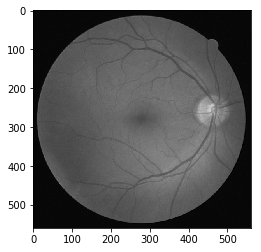

In [6]:
#resized images
ix = 9
plt.imshow(np.dstack((X_test[ix],X_test[ix],X_test[ix])))
plt.show()
# tmp = np.squeeze(Y_train[ix]).astype(np.float32)
# plt.imshow(np.dstack((tmp,tmp,tmp)))
# plt.show()

In [7]:
X_test_shaped = X_test.reshape(-1,1, 560, 560)/255
X_test_shaped = X_test_shaped.astype(np.float32)

In [22]:
eye_test_dataset = eye_dataset(X_test_shaped[3:4], train=False)
test_loader = torch.utils.data.DataLoader(dataset=eye_test_dataset, batch_size=1,
                                         shuffle=False)

In [20]:
model = ResNet([3, 3, 3])
model.cuda()
state_dict = torch.load('data/eyeResults/res_dilAgam_c180_2.pth')
model.load_state_dict(state_dict)
model.eval()

ResNet(
  (conv): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (layer1): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ResidualBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (b

In [23]:
res = []
for im in test_loader:
    image = Variable(im.type(torch.FloatTensor).cuda())
    #image = image.unsqueeze(0)
    y_pred = model(image)
    res.append(y_pred)


In [24]:
def res_show(img, idx):
    result = img.reshape(560,560,-1)
    result = result.data.cpu().numpy()
    result = np.squeeze(result>.3).astype(np.float32)*255
#     x = resize(result, (584, 565, 1), mode='constant', preserve_range=True)
#     x = np.squeeze(x).astype(np.float32)
    fig = plt.figure(figsize=(10,10))
    ax1 = fig.add_subplot(111)
    ax1.imshow(np.dstack((result,result,result)))
    
    topBorderWidth =20
    bottomBorderWidth =4
    leftBorderWidth =4
    rightBorderWidth=1
    outputImage = cv2.copyMakeBorder(
                 np.dstack((result,result,result)), 
                 topBorderWidth, 
                 bottomBorderWidth, 
                 leftBorderWidth, 
                 rightBorderWidth, 
                 cv2.BORDER_CONSTANT, 
                 value=0
              )
    
    path_res = 'data/DRIVE/res_1/'+str(idx)+'dil_res_mask.png'
    cv2.imwrite(path_res, outputImage)
    plt.show()
#res_show(res[0][0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


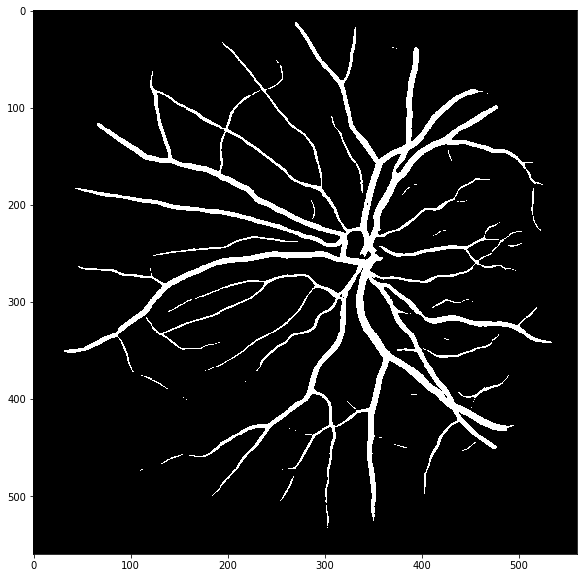

In [25]:
res_show(res[0][0],3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


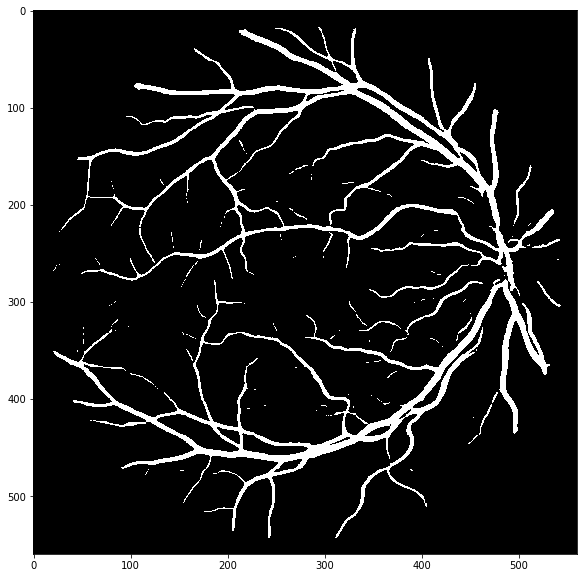

In [40]:
res_show(res[5][0],20)

(584, 565)

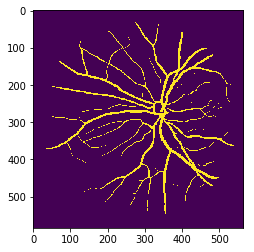

In [29]:
img1 = cv2.imread('data/DRIVE/res_1/3dil_res_mask.png', cv2.IMREAD_GRAYSCALE)
true_img1 = cv2.imread('data/DRIVE/test/1st_manual/04_manual1.jpg', cv2.IMREAD_GRAYSCALE)
true_y = true_img1.flatten()
img_flat = img1.flatten()
#plt.axes = figsize(10,10)
plt.imshow(img1)
img1.shape

In [30]:
for i in range(len(true_y)):
    if true_y[i] >100:
        true_y[i] =1
    else:
        true_y[i] =0
    if img_flat[i] >250:
        img_flat[i] =1
    else:
        img_flat[i] =0

In [31]:
count = 0
for i in range(len(true_y)):
    if true_y[i] == img_flat[i]:
        count +=1
print(count/len(true_y))

0.9663322827009334


In [32]:
fpr, tpr, thresholds = sklearn.metrics.roc_curve(true_y, img_flat, pos_label=1)
roc_auc = sklearn.metrics.auc(fpr, tpr)

In [33]:
print(roc_auc)

0.8391256225147098
